In [58]:
import torch
torch.set_default_dtype(torch.float64)
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import Variable
from matplotlib import cm
from torch import autograd
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import scipy.io
from IPython.display import clear_output


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

def batch_hessian(func, x):
    jacobian = batch_jacobian(func, x, create_graph=True)
    hessians = []
    for i in range(jacobian.size(1)):
        grad = autograd.grad(jacobian[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessians.append(grad.unsqueeze(1))
    return torch.cat(hessians, dim=1)

Using device: cuda:0


In [59]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_hidden_layers, activation=torch.tanh):  # 引入activation参数
        # NL是有多少层隐藏层
        # NN是每层的神经元数量
        super(Net, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)   #Input
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])  #Hidden
        self.output_layer = nn.Linear(hidden_size, output_size)  #Output
        self.activation = activation  # 保存激活函数

    def forward(self, x):
        x = self.activation(self.input_layer(x))  # 使用保存的激活函数
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x


model = Net(input_size=2,output_size=6,hidden_size=20,num_hidden_layers=4).to(device)
# 默认仍然使用tanh激活函数
# 如果需要更改激活函数，可以在实例化Net时传入新的激活函数
# 例如：Net(3, 10, activation=torch.relu)
 

In [60]:
L = 800 ##nm
h = 150 ##nm
geom = [0,L]

time_length= 0.1 ##s
TimeDomain = [0,time_length]

def generate_data(num_domain,num_init,num_bound):   ##（x,t）
     ##域内点 points in domain  
    x_domain = torch.rand(num_domain, 1) * L   # 生成均匀分布在 [0, L] 内的 x
    t_domain = torch.rand(num_domain, 1) * time_length   # 生成均匀分布在 [0, T] 内的 t
    points_domain = torch.cat((x_domain, t_domain), dim=1)
    # print(points_domain,points_domain.shape)

    ##初始点 points in initial 
    x_init = torch.rand(num_init, 1) * L   # 生成均匀分布在 [0, L] 内的 x
    t_init = torch.zeros(num_init, 1)      # 生成size大小的全0张量  [X,0]
    points_init = torch.cat((x_init, t_init), dim=1)
    # print(points_init,points_init.shape)

    ##边界点 points on boundary
    x_bound_left = torch.zeros(num_bound, 1)   # 生成[0,T]  左边界
    x_bound_right = torch.full((num_bound, 1),L)  # 生成[L,T]  右边界
    t_bound = torch.rand(num_bound, 1) * time_length   # 生成均匀分布在 [0, T] 内的 t
    points_bound_left = torch.cat((x_bound_left, t_bound), dim=1)  # 生成[0,T]  左边界
    points_bound_right = torch.cat((x_bound_right,t_bound), dim=1)  # 生成[L,T]  右边界
    # print(points_bound_left,points_bound_left.shape)
    # print(points_bound_right,points_bound_right.shape)

    # 合并所有点
    points = torch.cat((points_domain, points_init, points_bound_left, points_bound_right), dim=0)
    # print(points,points.shape)
    return points


# generate_data(10,5,5)


In [61]:
D_A = 6  #6nm^2/s
kf_11 = 0
kf_21 = 0
kf_12 = 0

N_SA = 90  
N_SB = 48  #nm^{-3}

def pde(coords):
    #前置定义过程
    coords = coords.clone().detach().requires_grad_(True)  # Ensure coords require grad
    grads = batch_jacobian(model , coords, create_graph= True)
    hessians = batch_hessian(model, coords)

    #PDE的定义过程： 
    c_a = model(coords)[:,0]  #predicted solution
    c_bc = model(coords)[:,1]  #predicted solution
    c_c = model(coords)[:,2]  #predicted solution
    c_ab = model(coords)[:,3]  #predicted solution
    c_abb = model(coords)[:,4]  #predicted solution
    c_aab = model(coords)[:,5]  #predicted solution

    #微分项
    dca_dx = grads[:,0,0]  #d_ca/dx
    dcbc_dx = grads[:,1,0]  #d_cbc/dx
    dcc_dx = grads[:,2,0]  #d_cc/dx
    dcab_dx = grads[:,3,0]  #d_cab/dx
    dcabb_dx = grads[:,4,0]  #d_cabb/dx
    dcaab_dx = grads[:,5,0]  #d_caab/dx

    #公共求和项目
    C_sigma_bottom = c_a + c_bc + c_c + c_ab +c_abb + c_aab
    C_sigma_up = c_bc + c_c + c_ab +c_abb + c_aab
    dsigma_dx = dcbc_dx + dcc_dx + dcab_dx + dcabb_dx + dcaab_dx
    D_star = D_A * (C_sigma_up / C_sigma_bottom)

    ##Eq 4:
    dca_dt = grads[:,0,1]  #d_ca/dt
    dca_dxx = hessians[:,0, 0]  #d^2_ca/dx^2
    eq_1 = dca_dt - D_star * dca_dxx - D_A * ((c_a * dsigma_dx - C_sigma_up * dca_dx )/ (C_sigma_bottom)**2) * dca_dx + \
           kf_11 * c_a * c_bc + kf_21 * c_a * c_ab 
    
    ##Eq 5:
    dcbc_dt = grads[:,1,1]  #d_cbc/dt
    dcbc_dxx = hessians[:,1,0]  #d^2_cbc/dx^2
    eq_2 = dcbc_dt - D_star * dcbc_dxx - D_A * ((c_a * dsigma_dx - C_sigma_up * dca_dx )/ (C_sigma_bottom)**2) * dcbc_dx + \
           kf_11 * c_a * c_bc + kf_12 * c_ab * c_bc

    ##Eq 6:
    dcc_dt = grads[:,2,1]  #d_cc/dt
    dcc_dxx = hessians[:,2,0]  #d^2_cc/dx^2
    eq_3 = dcc_dt - D_star * dcc_dxx - D_A * ((c_a * dsigma_dx - C_sigma_up * dca_dx )/ (C_sigma_bottom)**2) * dcc_dx - \
           kf_11 * c_a * c_bc - kf_12 * c_ab * c_bc
    
    ##Eq 7:
    dcab_dt = grads[:,3,1]  #d_cab/dt
    eq_4 = dcab_dt - kf_11 * c_a * c_bc + kf_21 * c_a * c_ab 

    ##Eq 8:
    dcabb_dt = grads[:,4,1]  #d_cabb/dt
    eq_5 = dcabb_dt - kf_12 * c_ab * c_bc

    ##Eq 9:
    dcaab_dt = grads[:,5,1]  #d_caab/dt
    eq_6 = dcaab_dt - kf_21 * c_a * c_ab

    loss_pde = torch.mean(eq_1 ** 2) + torch.mean(eq_2 ** 2) + torch.mean(eq_3 ** 2) + \
               torch.mean(eq_4 ** 2) + torch.mean(eq_5 ** 2) + torch.mean(eq_6 ** 2)
    
    ###########################################PDE 部分定义结束 ##############################################################
    ##边界条件 BC  Neumann-BC
    BC_mask_left = (coords[:, 0] == geom[0]) 
    BC_mask_righ = (coords[:, 0] == geom[1])

    ca_BC_left = batch_jacobian(model, coords[BC_mask_left],create_graph= True)[:,0]
    cbc_BC_left = batch_jacobian(model, coords[BC_mask_left],create_graph= True)[:,1]
    cc_BC_left = batch_jacobian(model, coords[BC_mask_left],create_graph= True)[:,2]

    ca_BC_righ = batch_jacobian(model, coords[BC_mask_righ],create_graph= True)[:,0]
    cbc_BC_righ = batch_jacobian(model, coords[BC_mask_righ],create_graph= True)[:,1]
    cc_BC_righ = batch_jacobian(model, coords[BC_mask_righ],create_graph= True)[:,2]
    loss_bc = torch.mean(ca_BC_left**2) + torch.mean(cbc_BC_left**2) + torch.mean(cc_BC_left**2) + \
              torch.mean(ca_BC_righ**2) + torch.mean(cbc_BC_righ**2) + torch.mean(cc_BC_righ**2)

    ##初始条件 IC
    IC_mask = (coords[:, 1] == TimeDomain[0])
    IC_points = coords[IC_mask]

    selected_h = IC_points[IC_points[:,0]<=h]
    selected_L = IC_points[(IC_points[:,0]>=h) & (IC_points[:,0]<=L)]

    IC_ca_in = model(selected_h)[:,0]
    IC_ca_out = model(selected_L)[:,0]
    IC_cbc_in = model(selected_L)[:,1]
    IC_cbc_out = model(selected_h)[:,1]

    IC_cc = model(IC_points)[:,2]
    IC_ab = model(IC_points)[:,3]
    IC_abb = model(IC_points)[:,4]
    IC_aab = model(IC_points)[:,5]

    loss_ic = torch.mean((IC_ca_in - N_SA)**2) + torch.mean((IC_cbc_in -N_SB) **2) + torch.mean(IC_cc**2) + \
              torch.mean(IC_ab**2) + torch.mean(IC_abb**2) + torch.mean(IC_aab**2) + \
              torch.mean(IC_ca_out**2) + torch.mean(IC_cbc_out**2)

    total_loss = loss_pde + loss_ic + loss_bc

    return total_loss


    

Step: 198 | Loss: 18.895767: 100%|██████████| 200/200 [25:56<00:00,  7.78s/it] 

[5204.573860809172, 5134.862765644613, 5038.725842800923, 4901.235894212779, 4551.051931343826, 4442.7222162730695, 4355.75665707442, 4270.738129727223, 4247.294479913842, 4138.2249765199085, 3906.29670050763, 3172.7510635941267, 3046.856037250802, 2945.1015082223544, 2757.8391760907493, 2541.704516767936, 2395.2598856495965, 1889.2914833076306, 1577.0059244042184, 1517.9728092509788, 1493.6046884670147, 1482.6236601877686, 1444.0682159226426, 1431.9384457319434, 1349.0296591267395, 1320.0827295352897, 1314.8990737966071, 1273.1362240603385, 1269.17393921661, 1264.7257922349734, 1207.7782075023886, 1113.742346338461, 1091.8139090205648, 1042.6646565307535, 1015.431140036339, 967.165291977775, 949.8405875600049, 746.9776919293814, 727.4560480138498, 706.1505426022336, 673.8948898276767, 661.709473539469, 651.3425942195188, 628.1302362470693, 543.8854172258841, 520.2838402674205, 519.7291255882276, 519.3861310421662, 519.0754766516869, 518.1605601237995, 468.33728159340944, 447.537316345

Text(0.5, 1.0, 'Loss of KAN')

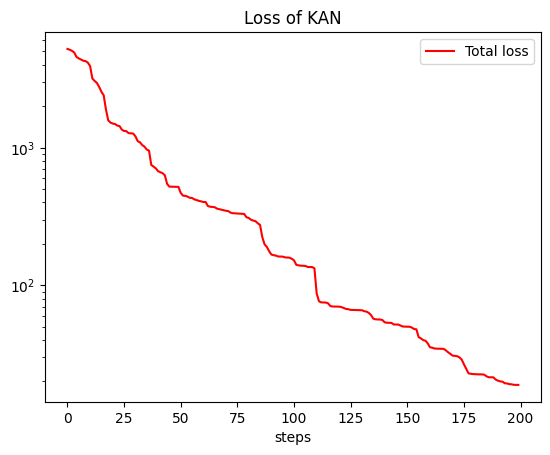

In [62]:
# 训练模型
coordinates = generate_data(5000,250,125).to(device)
coordinates.requires_grad = True  

Loss = []
writer = SummaryWriter()
def train():
    # optimizer = LBFGS(model.parameters(), lr=1,
    #                   history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    # optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
    # optimizer = optim.Adam(model.parameters(), lr)
    optimizer = optim.LBFGS(model.parameters(),
                        lr=1e-1,
                        max_iter=20,
                        max_eval=None,
                        tolerance_grad=1e-5,
                        tolerance_change=1e-9,
                        history_size=10,
                        line_search_fn="strong_wolfe")

    
    steps = 200
    pbar = tqdm(range(steps), desc='Training Progress')
    for step in pbar:
        # clear_output(wait=False)
        def closure():
            optimizer.zero_grad()
            loss = pde(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 2 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.6f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)
        Loss.append(closure().item())
        # l2_losses.append(l2.detach().numpy())
        # print("Current Loss: ",Loss[step])

train()
writer.close()

print(Loss)
plt.plot(Loss, color = "r")
plt.yscale('log')
plt.xlabel('steps')
plt.legend(['Total loss'])
plt.title('Loss of KAN') 

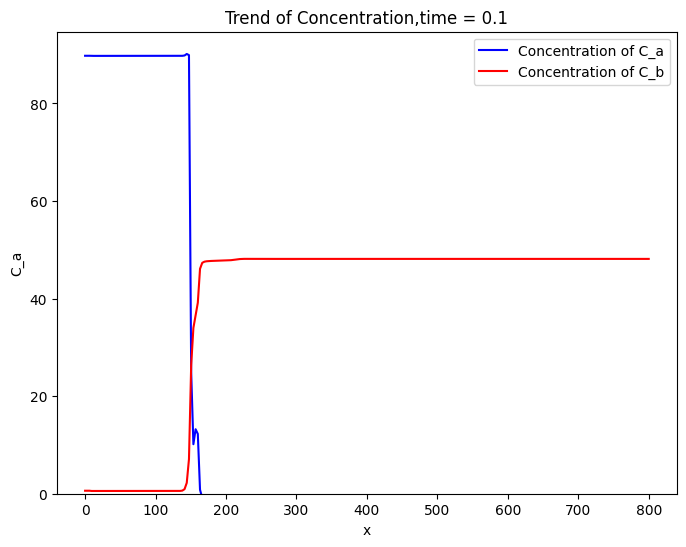

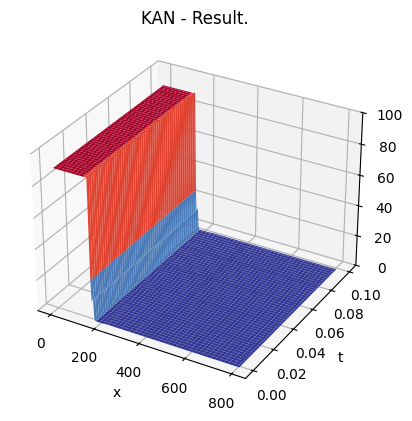

In [63]:
#画图
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
import matplotlib.pyplot as plt
x = np.linspace(0, L, 256)
t = np.linspace(0, time_length, 100)
ms_x, ms_t = np.meshgrid(x, t)
x = np.ravel(ms_x).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)
pt_x = torch.from_numpy(x).double().requires_grad_(True).to(device)
pt_t = torch.from_numpy(t).double().requires_grad_(True).to(device)

result = model(torch.cat([pt_x,pt_t],1)).data.cpu().numpy()
c_a = result[:,0]
c_b = result[:,1]

c_a=c_a.reshape(100,256)
c_b=c_b.reshape(100,256)

component_x = np.linspace(0, L, 256)

plt.figure(figsize=(8, 6))
plt.plot(component_x, c_a[1], label=r'Concentration of C_a', color='b')
plt.plot(component_x, c_b[1], label=r'Concentration of C_b', color='r')
plt.title('Trend of Concentration,time = 0.1')
plt.xlabel('x')
plt.ylabel('C_a')
plt.ylim(bottom=0)
plt.legend()
# plt.grid(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_zlim([0, 100])
ax.plot_surface(ms_x, ms_t, c_a, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('KAN - Result.') 
plt.show(fig)